In [109]:
# import the usual libraries we'll need
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'


# Running basic analysis

First, let's take a look at the data in general. The initial focus will be on a single company, JP Morgan (ticker: `JPM`). We'll expand this out later as needed.


In [110]:
# Loading the dataset
data = pd.read_csv('sp500_stocks.zip')
df = data[data['Symbol'] == 'JPM']
# df = data.copy()
print(df.shape)
print(df.head())
df.describe()
# data.shape

(3639, 8)
              Date Symbol  Adj Close      Close       High        Low  \
982530  2010-01-04    JPM  29.497789  42.849998  42.990002  41.669998   
982531  2010-01-05    JPM  30.069157  43.680000  43.840000  42.779999   
982532  2010-01-06    JPM  30.234362  43.919998  44.090000  43.310001   
982533  2010-01-07    JPM  30.833282  44.790001  45.119999  43.610001   
982534  2010-01-08    JPM  30.757544  44.680000  44.700001  44.080002   

             Open      Volume  
982530  41.790001  35460500.0  
982531  42.790001  41208300.0  
982532  43.450001  27729000.0  
982533  43.790001  44864700.0  
982534  44.369999  33110100.0  


,Adj Close,Close,High,Low,Open,Volume
count,3639.000000,3639.000000,3639.000000,3639.000000,3639.000000,3.639000e+03
mean,77.666612,89.607450,90.435633,88.749805,89.590473,1.965274e+07
std,44.855926,42.980973,43.320094,42.620652,42.955768,1.373047e+07
min,20.035660,28.379999,29.129999,27.850000,28.250000,3.220500e+06
25%,39.393471,53.080000,53.645000,52.570002,53.049999,1.116480e+07
50%,71.058441,86.769997,87.309998,85.959999,86.580002,1.508760e+07
75%,109.687885,118.629997,120.004997,117.594997,118.905003,2.364690e+07
max,204.789993,204.789993,205.880005,202.809998,204.389999,2.172942e+08


We can see `8 columns` and a little over `3639 rows`
### Interesting notes on the columns provided:
- `Date` goes back to 2010. An entry for every day the market was open until the most recently published S&P day (June 18th, 2024 in this case, YMMV depending when you download the data set)
- `Adj Close` takes the daily close and adjusts the price based on dividends, stock splits, etc. This is important when considering the stock long term. For example, a stock split will usually show a massive drop in a closing price, when in reality the real price will be unaffected.
- `Close` and `Open` are self explanatory, but they're also likely to be a major focus of any model given their nature, and are worth calling out as an interesting column.
- `Volume` may be an interesting column as well. It could show the strength of a particular stock price movement. I.e: If a stock price has a sudden price change for the day, but the volume is smaller than usual, then it may not indicate much other than an errant HFT. However, if we see a day with a lower price change and high volume, that could indicate that the market sees the stock headed toward that particular direction, and is worth taking into consideration for a future days price, especially if we see multiple days of high volume trading.

## Comparing Variables to closing price.

Given what we know of the columns, let's see if there are any immediately interesting relationships between them and the adjusted closing price (we will ignore the close price)

To start, let's simply compare the time to the adjusted closing price. We know the S&P has gone up consistently over its life, but it gives us a visual baseline to compare other variables.

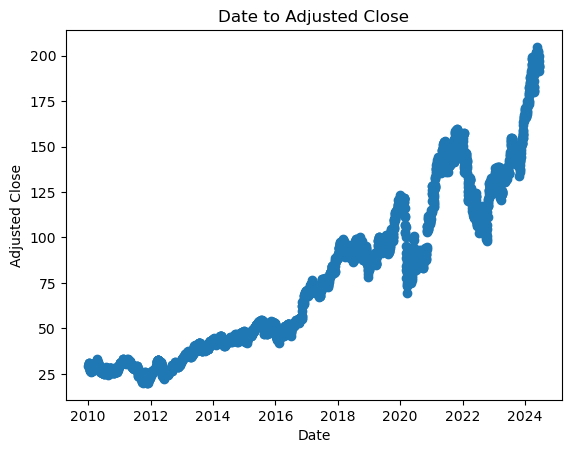

In [111]:
date = df['Date']
adj_close = df['Adj Close']
plt.scatter(pd.to_datetime(date), adj_close, label='Date to Adjusted Close')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Date to Adjusted Close')
plt.show()

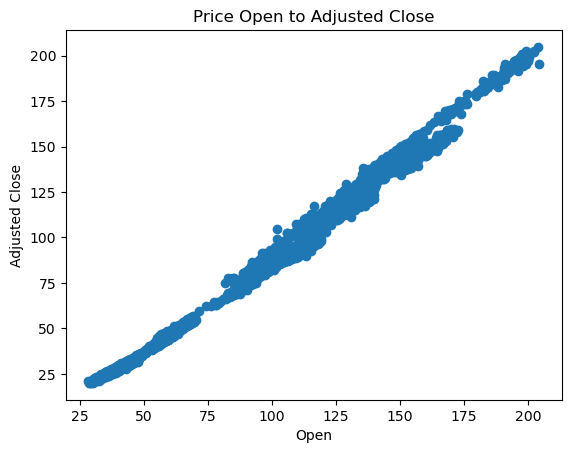

In [112]:
# relationship between adj close and open
open = df['Open']
adj_close = df['Adj Close']
plt.scatter(open, adj_close, label='Price open to Adjusted Close')
plt.xlabel('Open')
plt.ylabel('Adjusted Close')
plt.title('Price Open to Adjusted Close')
plt.show()

Ok, this doesn't show us much. We know the S&P has had generally positive returns over time. This is likely showing just that.

Let's move on to trying the volume

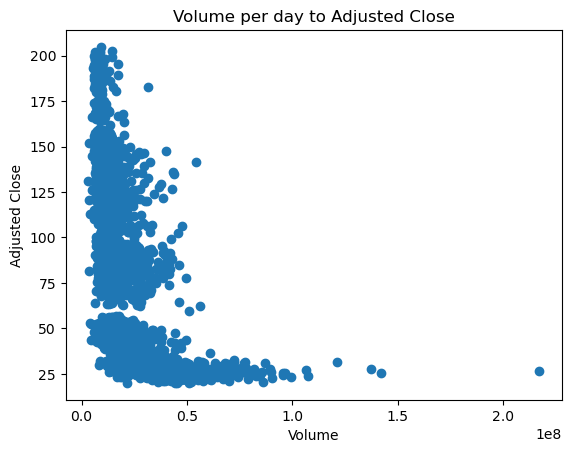

In [113]:
volume = df['Volume']
adj_close = df['Adj Close']
plt.scatter(volume, adj_close, label='Price open to Adjusted Close')
plt.xlabel('Volume')
plt.ylabel('Adjusted Close')
plt.title('Volume per day to Adjusted Close')
plt.show()

# Adding more context
Let's add some % changes to each and lag data on the returns

In [114]:
# Comparing with Multiple Regression
df.dropna(inplace=True)

# Add a percentage of return. We can use these to determine if we want to buy
# The stock or not (as opposed to trying to predict the exact price of a stock,
# we instead try to predict whether the stock will rise or fall)
df['Returns'] = np.log(df.Close.pct_change() + 1 )



In [115]:
def lag(df, lags, column='Returns'):
    names = []
    for i in range(1,lags+1):
        lagName = f"{column}_lag_{i}"
        df[lagName] = df[column].shift(i)
        names.append(lagName)
    return names


In [116]:
# Add lags to the dataframe so we can judge based off prior trading days.
lagnames = lag(df,5)
lagVolumesNames = lag(df, 5, column="Volume")
features = lagnames + lagVolumesNames
dependent = 'Returns'

In [117]:
# drop the NaN data. We have enough here to not worry about a few missing rows IMO
df.dropna(inplace=True)

# get our X and Y
X = df[features]
y = df[dependent]
# Next, create the train and test splits. Don't shuffle the values because this is a timeseries. Simply split the data.
# Random state set for repeatable tests. and 42 is the answer to everything.
X_train, X_test,y_train, y_test = train_test_split(X,y, shuffle=False, random_state=42, test_size=0.2)


In [118]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [119]:
y_pred = model.predict(X_test)


In [120]:
# save the direction. Because why not.
X_test['Direction'] = [1 if i > 0 else -1 for i in y_pred]

In [121]:
# Let's try this with SM as well because they have the better classical stat ouput
XSM = sm.add_constant(X_train)
sr_model = sm.OLS(y_train, XSM).fit()
sr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.583
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           4.86e-12
Time:                        13:42:27   Log-Likelihood:                 7577.3
No. Observations:                2906   AIC:                        -1.513e+04
Df Residuals:                    2895   BIC:                        -1.507e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      1.846      0.065   -7.71e-05       0.003
Returns_lag_1    -0.1164      0.019     -6.214      0.000      -0.153      -0.080
Returns_lag_2     0.0644      0.019      3.414      0.001       0.027       0.101
Returns_lag_3    -0.0253      0.019     -1.338      0.181      -0.062       0.012
Returns_lag_4    -0.0613      0.019     -3.252      0.001      -0.098      -0.024
Returns_lag_5     0.0146      0.019      0.781      0.435      -0.022       0.051
Volume_lag_1  -3.668e-11   3.74e-11     -0.981      0.326    -1.1e-10    3.66e-11
Volume_lag_2   4.303e-11   4.16e-11      1.033      0.302   -3.86e-11    1.25e-10
Volume_lag_3  -3.282e-11    4.2e-11     -0.782      0.435   -1.15e-10    4.95e-11
Volume_lag_4  -8.419e-11   4.16e-11     -2.026      0.043   -1.66e-10    -2.7e-12
Volume_lag_5   7.508e-11   3.72e-11      2.021      0.043    2.23e-12    1.48e-10
==============================================================================
Omnibus:                      473.316   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8419.404
Skew:                          -0.138   Prob(JB):                         0.00
Kurtosis:                      11.334   Cond. No.                     3.44e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

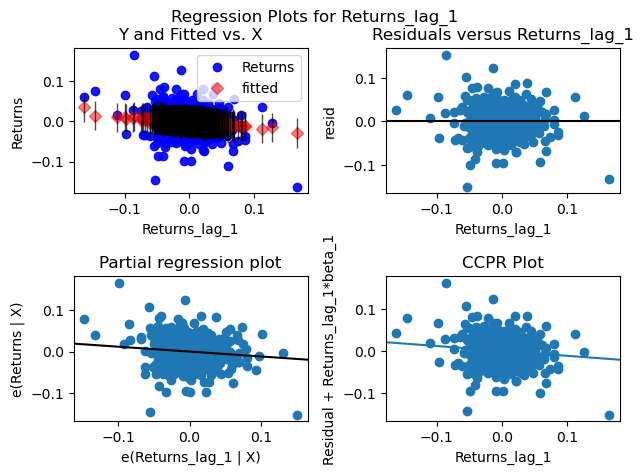

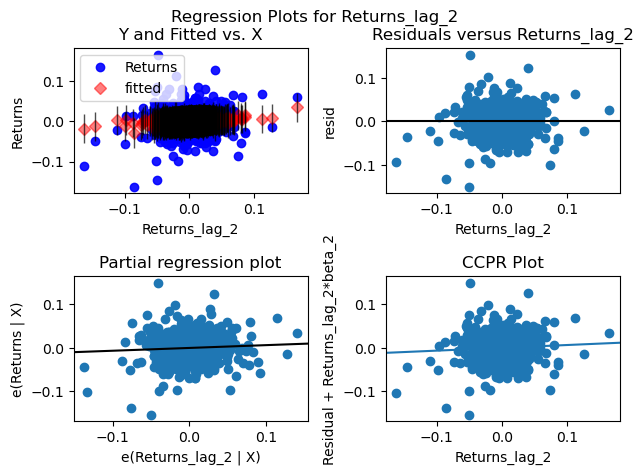

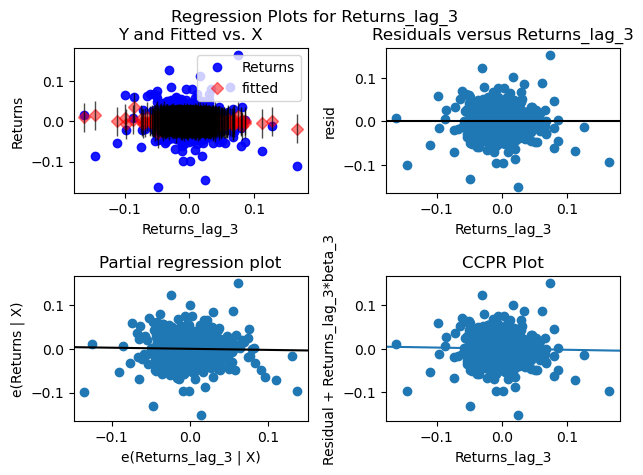

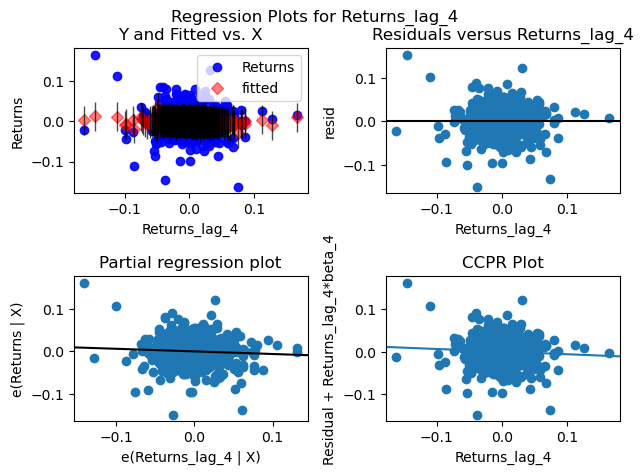

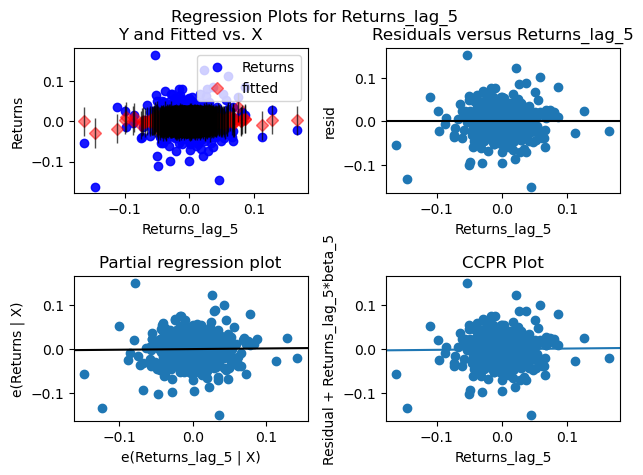

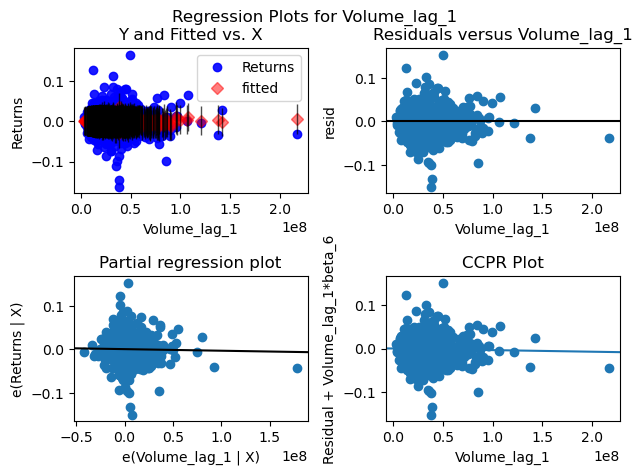

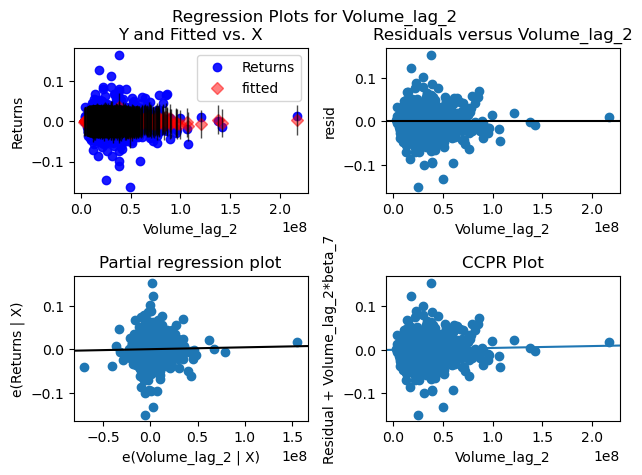

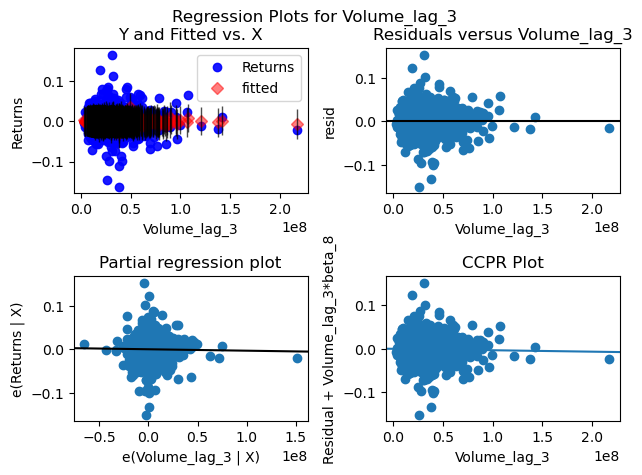

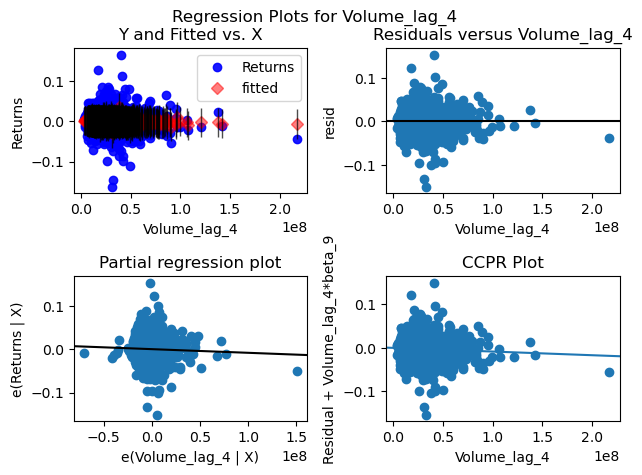

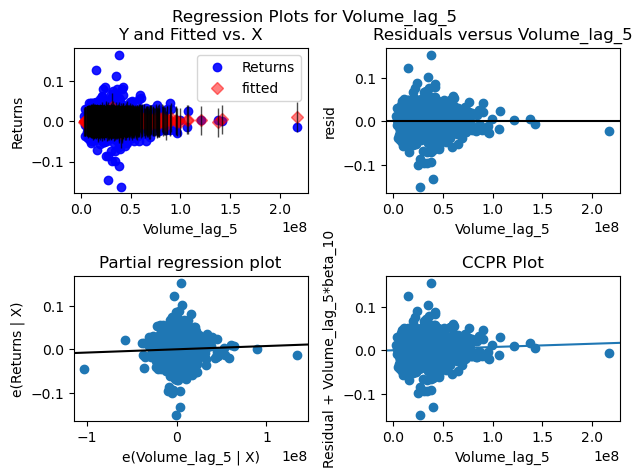

In [122]:
# graph time....this is a lot of graphs.
for i in features:
    sm.graphics.plot_regress_exog(sr_model, i)
plt.show()

In [123]:
# And now, some predictions from the SK model
# Making prediction
dataset = pd.DataFrame(y_pred,y_test)
display(dataset)
# Evaluating the values
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE : {mse}')
print(f'R² : {r2}')

,0
Returns,
0.008533,0.000537
-0.008006,-0.000316
-0.004027,0.002263
0.011314,0.000679
-0.010851,-0.000963
...,...
-0.014668,0.003498
0.011060,0.000032
0.000619,-0.000043


MSE : 0.00023635889088341027
R² : -0.03463777134952317


# Summary
I could try to improve this methodology, but given the incredibly low MSE and terrible R² scores, I'm going to stop here. I personally don't think linear regression is a good option for predicting a stock price.